# Running instructions
- set input and output paths in the parameters section. The model will read all files in the input folder and treat each of them as a different input modality.
- Modlaity input files should be in tap separated format
- files in the ignore_files list will be ignored
- label_file will be the file used for constructing the labels
- model parameters can be changed to expolre and improve model performance

When parameters are set, the notebook can be run sequentially from beginning to end. It will create an output folder and store the outputs.

OBS: some cells are there for making the notebook work on a DNANexus jupyterlab session (installing libraries, downloading data, uploading output). Those can be commented out if the notebook is not run in such an instance.


# PARAMETERS
Set here the parameters before running the notebook. Model parameters can be left to default.

In [1]:
# analysis parameters
survival_th = 2 #threshold betw. low and high survival
# PATHS and files
input_path = 'model_input_genes'
output_path = 'model_output_genes'

ignore_files = ['README.md'] # files that are not feature input data
label_file = 'pheno_data.tsv' # name of the label file

# model_parameters
L1_REGULARIZATION = 0.5 #l1 regularization parameter
EPOCHS = 100    #number of training epochs
VALIDATION_SPLIT = 0.1    #fraction of data held out for validation
BATCH_SIZE = 1    # size of training batches


In [50]:
# INSTALLING MACHINE LEARNING LIBRARIES. SKIP IF NOT REQUIRED
! pip install tensorflow
! pip install sklearn

ERROR: Could not find a version that satisfies the requirement scikitlearn (from versions: none)
ERROR: No matching distribution found for scikitlearn


In [2]:
# DOWNLOAD DATA FROM DNA NEXUS - SKIP IF NOT REQUIRED
!dx download "model_input_genes" -r

[===========================================================>] Completed 638 of 638 bytes (100%) /opt/notebooks/model_input_genes/pheno_data.tsvv
[===========================================================>] Completed 3,051,744 of 3,051,744 bytes (100%) /opt/notebooks/model_input_genes/Indel_VCFs.gene_scores_matrix.tsv.gzz
[===========================================================>] Completed 1,588,467 of 1,588,467 bytes (100%) /opt/notebooks/model_input_genes/SNP_VCFs.gene_scores_matrix.tsv.gzz
[===========================================================>] Completed 293,991 of 293,991 bytes (100%) /opt/notebooks/model_input_genes/SV_VCFs.DEL.gene_scores_matrix.tsv.gzz
[===========================================================>] Completed 317,021 of 317,021 bytes (100%) /opt/notebooks/model_input_genes/SV_VCFs.INS.gene_scores_matrix.tsv.gzz
[===========================================================>] Completed 228,801 of 228,801 bytes (100%) /opt/notebooks/model_input_genes/SNP_

In [3]:
# IMPORTS
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from os import listdir
import pickle
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
This section loads all the data and transforms it into a format useful for model training

In [4]:
#FUNCTIONS
# this function handles missing values, substituting them in a way that does not affect classifier performance
def fill_nans(df):
    #frist substitute nans with coulumns mean, that does not affect performance
    filled_df = df.fillna(df.mean())
    #for all nan columns, put zeros as constant value
    filled_df = filled_df.fillna(0)
    return filled_df


In [5]:
#load all feature files and clean them
file_names = [f for f in listdir(input_path)]
dataframes = {}
for fname in file_names:
    if not (fname in ignore_files or fname==label_file):
        df = pd.read_csv(input_path+'/'+fname,sep='\t',index_col=0)
        df = fill_nans(df)
        dataframes[fname] = df
        
# list of modalities, identified by file names
modalities = dataframes.keys() 

# load phenotipes for label construction
labels_df = pd.read_csv(input_path+'/'+label_file,sep='\t',index_col=0)

In [6]:
# prepares input matrices
X0 = [x.values for x in dataframes.values()]
# z-score inputs in each modality
scaler = StandardScaler()
X = [scaler.fit_transform(x) for x in X0]
# prepare labels for bynary classification, low survival=1, high survival=0 
Y = np.array([1 if y<survival_th else 0 for y in labels_df['Phe3_Surv_years'].values])

# MODEL DEFINITION
In this section the model is build and a summary printed. The building process automatically adapto to the number and shape of different modalities

In [7]:
input_layers = []
for m,m_name in enumerate(modalities):
    input_layer = keras.Input(shape=X[m].shape[1:], name=f"m{m+1}_input")
    input_layers.append(input_layer)

m_output_layers = []
for m,m_name in enumerate(modalities):
    output_layer = layers.Dense(1,activation='relu',
                                kernel_regularizer=regularizers.l1(l1=L1_REGULARIZATION),
                                name=f"m{m+1}_output")(input_layers[m])
    m_output_layers.append(output_layer)
# concatenation layer
concatenation = layers.concatenate(m_output_layers,name='concatenated_modalitites')
# logisitc regression layer
prediction = layers.Dense(1, name="output_layer")(concatenation)

model = keras.Model(
    inputs=input_layers,
    outputs=[prediction],
)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m1_input (InputLayer)           [(None, 19376)]      0                                            
__________________________________________________________________________________________________
m2_input (InputLayer)           [(None, 9952)]       0                                            
__________________________________________________________________________________________________
m3_input (InputLayer)           [(None, 2177)]       0                                            
__________________________________________________________________________________________________
m4_input (InputLayer)           [(None, 2349)]       0                                            
______________________________________________________________________________________________

# MODEL COMPILATION
In this section the loss function, the optimizer and the metrics to track during training are defined

In [9]:
#model compilation
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

# MODEL TRAINING
Here the model is trained on the data, using the parameters defined in the parameters section. Change to verbose=False if the display of the training step is not wanted

In [10]:
# train model
history = model.fit(X,Y,epochs=EPOCHS,validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE, shuffle=True,verbose=2)

Epoch 1/100
18/18 - 1s - loss: 150.4494 - accuracy: 0.5000 - val_loss: 62.0711 - val_accuracy: 1.0000
Epoch 2/100
18/18 - 0s - loss: 48.0395 - accuracy: 0.4444 - val_loss: 22.2569 - val_accuracy: 1.0000
Epoch 3/100
18/18 - 0s - loss: 23.8000 - accuracy: 0.4444 - val_loss: 11.1791 - val_accuracy: 1.0000
Epoch 4/100
18/18 - 0s - loss: 18.1156 - accuracy: 0.4444 - val_loss: 8.3988 - val_accuracy: 1.0000
Epoch 5/100
18/18 - 0s - loss: 16.4263 - accuracy: 0.4444 - val_loss: 7.4633 - val_accuracy: 1.0000
Epoch 6/100
18/18 - 0s - loss: 15.7391 - accuracy: 0.4444 - val_loss: 6.9085 - val_accuracy: 1.0000
Epoch 7/100
18/18 - 0s - loss: 15.2491 - accuracy: 0.4444 - val_loss: 6.5438 - val_accuracy: 1.0000
Epoch 8/100
18/18 - 0s - loss: 14.8435 - accuracy: 0.4444 - val_loss: 6.0484 - val_accuracy: 1.0000
Epoch 9/100
18/18 - 0s - loss: 14.4252 - accuracy: 0.4444 - val_loss: 5.7196 - val_accuracy: 1.0000
Epoch 10/100
18/18 - 0s - loss: 14.0707 - accuracy: 0.4444 - val_loss: 5.3123 - val_accuracy: 1.

# Feature ranking
Here features are ranked for each modality separately

In [11]:
#feature rakings
output_dfs = {}

mod_w = model.get_layer('output_layer').get_weights()[0].flatten()
for m,m_name in enumerate(modalities):
    features_w = model.get_layer(f'm{m+1}_output').get_weights()[0].flatten()
    tot_w = features_w*mod_w[m]
    mod_order = tot_w.argsort()[::-1] # to rank from larger to smaller
    mod_ranks = mod_order.argsort()
    
    df = pd.DataFrame(columns=['Feature_ID','Rank','Score'])
    df['Feature_ID'] = dataframes[m_name].columns
    df['Rank'] = mod_ranks
    df['Score'] = tot_w
    
    output_dfs[m_name] = df.sort_values(by=['Rank'])
    
# modality weights
mod_df = pd.DataFrame(columns=['Modality','Weight'])
mod_df['Modality'] = modalities
mod_df['Weight'] = mod_w
    

# SAVE OUTPUT
This section builds an output folder and saves the ranked features of each modality in a separate file. The fitted model and the training history asre saved in a subfolder for forther analysis.

In [12]:
# make model_output dir
Path(output_path).mkdir(parents=True, exist_ok=True)

# save_dataframes
for key in output_dfs.keys():
    output_dfs[key].to_csv(output_path +'/'+key,sep='\t',index=False,header=output_dfs[key].columns)

# save modality weigths
mod_df.to_csv(output_path +'/modality_weights',sep='\t',index=False,header=mod_df.columns)

# save trained model
model_path = output_path+'/'+'model'
Path(model_path).mkdir(parents=True, exist_ok=True)
model.save(model_path)

# save training history
with open(model_path+'/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


INFO:tensorflow:Assets written to: model_output_genes/model/assets


In [13]:
# upload output to DNAnexus - skip if not needed
!dx upload -r model_output_genes

[===========================================================>] Uploaded 202,546 of 202,546 bytes (100%) model_output_genes/Indel_VCFs.gene_scores_matrix.tsv.gz
[===========================================================>] Uploaded 106,618 of 106,618 bytes (100%) model_output_genes/SNP_VCFs.gene_scores_matrix.tsv.gz
[===========================================================>] Uploaded 24,367 of 24,367 bytes (100%) model_output_genes/SV_VCFs.DEL.gene_scores_matrix.tsv.gz
[===========================================================>] Uploaded 26,487 of 26,487 bytes (100%) model_output_genes/SV_VCFs.INS.gene_scores_matrix.tsv.gz
[===========================================================>] Uploaded 69,785 of 69,785 bytes (100%) model_output_genes/SNP_VCFs.cS2G_scores_matrix.tsv.gz
[===========================================================>] Uploaded 493 of 493 bytes (100%) model_output_genes/SV_VCFs.INV.gene_scores_matrix.tsv.gz
[======================================================

# Plots

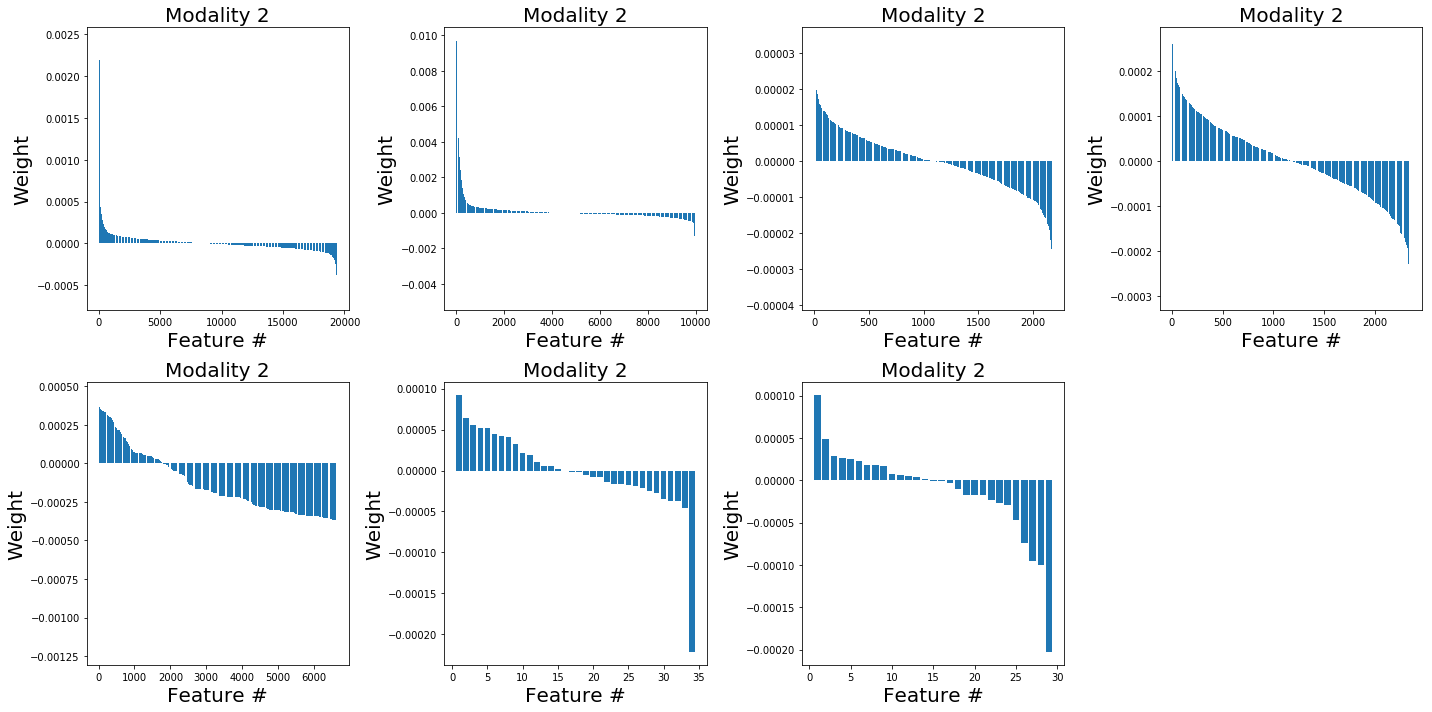

In [51]:
#feature weights
nrows = 2
ncols = np.ceil(len(modalities)/2.0)
plt.figure(figsize =(5*ncols,5*nrows))
for i,md in enumerate(output_dfs.keys()):
    ws = output_dfs[md].Score
    x = range(1,len(ws)+1)
    ax = plt.subplot(nrows,ncols,i+1)
    ax.bar(range(1,len(ws)+1),ws)
    ax.set_title(f'Modality {1+1}',fontsize=20)
    ax.set_xlabel('Feature #',fontsize=20)
    ax.set_ylabel('Weight',fontsize=20)
plt.tight_layout()

Text(0, 0.5, 'Weight')

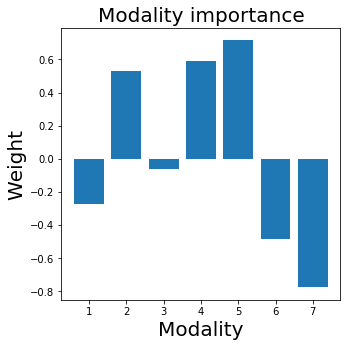

In [38]:
# modality weights
plt.figure(figsize=(5,5))
ws = mod_df.Weight.values
mname = mod_df.Modality.values
plt.bar(range(1,len(ws)+1),ws)
plt.title('Modality importance',fontsize=20)
plt.xlabel('Modality',fontsize=20)
plt.ylabel('Weight',fontsize=20)